In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pre-processes the given DataFrame by dropping specified columns and handling missing values.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to be pre-processed.

    Returns:
    - pd.DataFrame: Pre-processed DataFrame.
    """
    # Columns to drop
    cols = ['TimeStamp', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements']
    
    # Drop specified columns
    for i in cols:
        df.drop(columns=[i], inplace=True)

    # Drop rows with missing values and reset index
    df.dropna(inplace=True)
    df = df.reset_index(drop=True).copy()
    
    return df

def read_dirs(main_directory: str) -> pd.DataFrame:
    """
    Reads data from multiple files in specified directories and concatenates them into a single DataFrame.

    Parameters:
    - main_directory (str): Main directory containing subdirectories with data files.

    Returns:
    - pd.DataFrame: Concatenated DataFrame.
    """
    concatenated_df = []

    # Loop through subdirectories in the main directory
    for subdir in os.listdir(main_directory):
        if subdir.startswith('SS'):
            subdir_path = os.path.join(main_directory, subdir)

            if os.path.isdir(subdir_path):
                # Loop through files in the subdirectory
                for file_name in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file_name)

                    if os.path.isfile(file_path):
                        # Read and preprocess data based on file name
                        if '6MWT' in file_name:
                            dataset = pd.read_csv(file_path)
                            dataset['label'] = 'walk'
                            concatenated_df.append(pre_process(dataset))

                        elif 'easy' in file_name:
                            dataset = pd.read_csv(file_path)
                            dataset['label'] = 'easy'
                            concatenated_df.append(pre_process(dataset))

                        elif 'medium' in file_name:
                            dataset = pd.read_csv(file_path)
                            dataset['label'] = 'medium'
                            concatenated_df.append(pre_process(dataset))

                        elif 'hard' in file_name:
                            dataset = pd.read_csv(file_path)
                            dataset['label'] = 'hard'
                            concatenated_df.append(pre_process(dataset))

    # Concatenate all DataFrames into a single DataFrame
    concatenated_df = pd.concat(concatenated_df, ignore_index=True)
    
    return concatenated_df


#define your path here
main_directory = 'C:/Users/MP PC/Desktop/EEG signal processing'
eeg_data= read_dirs(main_directory)
eeg_data

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,...,RAW_AF8,RAW_TP10,AUX_RIGHT,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,label
0,0.976016,0.812655,0.415830,0.482251,0.706402,0.049015,-0.208601,0.563854,0.724275,0.445102,...,799.01100,767.98535,838.49817,0.413635,0.377136,0.804810,-2.975769,1.263580,-2.332764,walk
1,1.050657,1.041396,0.171741,0.286752,0.587928,0.627050,0.423119,0.228542,0.686048,0.532079,...,770.00000,986.77655,872.74725,0.443787,0.267822,0.842712,-0.545807,-5.114136,-0.553284,walk
2,1.050657,1.035761,0.792463,0.286752,0.587928,0.525994,0.419444,0.228542,0.686048,0.564308,...,811.50183,812.71063,865.09155,0.633484,0.226990,0.817871,1.308441,-7.200165,-10.602112,walk
3,1.050657,1.044157,0.627806,0.286752,0.587928,0.653424,0.317279,0.228542,0.686048,0.722676,...,810.69600,729.30400,642.27106,0.492371,0.177734,0.790283,-0.381317,-5.749664,-8.321686,walk
4,1.050657,1.127236,0.918152,0.286752,0.587928,0.853075,0.616951,0.228542,0.686048,0.845580,...,790.14655,815.53110,819.96340,0.466492,0.196777,0.825500,-1.278534,-2.123413,-5.405731,walk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6868,0.673764,0.509302,0.812756,1.284155,0.188235,-0.047655,0.737592,1.405758,0.299118,-0.357240,...,807.47253,844.94507,718.02200,-0.569641,-0.241089,0.758057,13.069458,13.749847,6.968384,medium
6869,0.673764,0.509302,0.812756,1.284155,0.188235,-0.047655,0.737592,1.405758,0.299118,-0.357240,...,769.19415,809.08420,943.26010,-0.631775,0.149963,0.772217,-9.031982,-1.173859,-15.192871,medium
6870,1.375983,0.694771,0.825896,1.089863,0.539347,0.055561,0.128271,0.615264,0.759044,0.150595,...,787.72894,763.95605,386.41025,-0.270935,-1.291931,0.663452,16.658325,-93.033905,26.251068,medium
6871,1.692149,0.703595,0.658926,1.294261,0.763817,0.146729,0.136671,0.817651,0.746043,0.130826,...,778.05860,853.00366,742.60070,-0.406799,0.014893,0.809753,-19.155579,-3.603821,-24.157562,medium


# Features Grouping

In [3]:
# Raw EEG data columns
raw_eeg = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']

# Frequency-based feature columns
eeg_frequency = ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9',
                 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7',
                 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8',
                 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']

# Gyro features
gyro = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']

# Accelerometer features
acc = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']

# All features
all_cols = eeg_data.columns

# Data Scaling

In [4]:
def to_normalize(data, label_column='label', threshold_mean=2, threshold_std=2):
    """
    Identifies columns in the DataFrame that need normalization based on mean and standard deviation thresholds.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - label_column (str): Name of the label column.
    - threshold_mean (float): Threshold for mean above which normalization is needed.
    - threshold_std (float): Threshold for standard deviation above which normalization is needed.

    Returns:
    - list: List of column names to be normalized.
    """
    temp_data = data.drop(columns=[label_column])

    columns_to_normalize = []

    for i, column in enumerate(temp_data.columns):
        mean = np.mean(temp_data[column])
        std_dev = np.std(temp_data[column])

        # Check if both mean and std are above the specified thresholds
        if abs(mean) > threshold_mean or std_dev > threshold_std:
            columns_to_normalize.append(column)

    return columns_to_normalize

def normalize_columns(data, columns_to_normalize):
    """
    Normalizes specified columns in the DataFrame using StandardScaler.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - columns_to_normalize (list): List of column names to be normalized.

    Returns:
    - pd.DataFrame: DataFrame with normalized columns.
    """
    normalized_data = data.copy()
    
    scaler = StandardScaler()

    for column in columns_to_normalize:
        column_data = normalized_data[column].values.reshape(-1, 1)
        normalized_column = scaler.fit_transform(column_data)
        normalized_data[column] = normalized_column.flatten()

    print("Normalization Completed")

    return normalized_data

# Identify columns to normalize
columns_to_normalize = to_normalize(eeg_data, threshold_mean=2, threshold_std=2)
print("Columns to Normalize:", columns_to_normalize)
print("**************************")

# Normalize specified columns
normalized_eeg_data = normalize_columns(eeg_data, columns_to_normalize)

Columns to Normalize: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
**************************
Normalization Completed


# Label Encoding

In [5]:
def label_encode_column(data, label_column):
    """
    Label encodes the specified column in the DataFrame using sklearn's LabelEncoder.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - label_column (str): Name of the label column to be encoded.

    Returns:
    - pd.DataFrame: DataFrame with label-encoded column.
    - dict: Mapping of original labels to encoded values.
    """
    encoded_data = data.copy()
    labels = encoded_data[label_column]
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit and transform labels
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Update the DataFrame with encoded labels
    encoded_data[label_column] = encoded_labels
    
    # Create a mapping of original labels to encoded values
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
    return encoded_data, label_mapping

# Label encode the 'label' column in the DataFrame
encoded_eeg_data, label_mapping = label_encode_column(normalized_eeg_data, label_column='label')

# Get class names list from label mapping
class_names_list = list(label_mapping.keys())

print("\nLabel Mapping:")
print(label_mapping)


Label Mapping:
{'easy': 0, 'hard': 1, 'medium': 2, 'walk': 3}


# Feature Selection

In [7]:
def feature_selection(data, method=None, xgb_threshold=0.01, mutual_info_threshold=0.1):
    """
    Performs feature selection on the input data based on the specified method.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - method (str): Method for feature selection ('rfe', 'select_from_model', 'mutual_info', or None for no selection).
    - xgb_threshold (float): Threshold for feature selection using XGBoost.
    - mutual_info_threshold (float): Threshold for feature selection using Mutual Information.

    Returns:
    - list: List of selected feature names.
    """
    X = data.drop(columns=['label'])
    y = data['label']

    num_features_to_select = 15
    
    if method == 'rfe':
        # Recursive Feature Elimination with Decision tree classifier as the base estimator
        model = DecisionTreeClassifier()  # You can replace with other estimators; tree model works best as estimators
        rfe = RFE(model, n_features_to_select=num_features_to_select)
        selected_features = X.columns[rfe.fit(X, y).support_]

    elif method == 'select_from_model':
        # SelectFromModel with XGBoost as the base estimator
        xgb_classifier = XGBClassifier()
        sfm = SelectFromModel(xgb_classifier, threshold=xgb_threshold, prefit=False)
        sfm.fit(X, y)
        selected_features = X.columns[sfm.get_support()]

    elif method == 'mutual_info':
        # Mutual Information
        mutual_info_values = mutual_info_classif(X, y)
        mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mutual_info_values})
        sorted_features_mutual_info = mutual_info_df.sort_values(by='Mutual_Info', ascending=False)['Feature'].values
        selected_features = sorted_features_mutual_info[mutual_info_df['Mutual_Info'] > mutual_info_threshold]

    else:
        selected_features = X.columns

    return selected_features.tolist()

#selected_features = feature_selection(encoded_eeg_data, method='select_from_model')
#print("Selected Features:", selected_features)

# Model Training

In [9]:
def train_all_classifiers(X, y, test_size=0.3, random_state=42, features=None):
    """
    Trains multiple classifiers on the input data, evaluates their performance, and generates confusion matrices.

    Parameters:
    - X (pd.DataFrame): Input features.
    - y (pd.Series): Target labels.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Seed for reproducibility.
    - features (list): List of selected feature names.

    Returns:
    - pd.DataFrame: Results DataFrame containing classifier performance metrics.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=random_state, max_depth=7),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state, max_depth=8, learning_rate=0.01),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state, max_depth=8),
        'XGBoost': XGBClassifier(random_state=random_state, max_depth=7, learning_rate=0.01)
    }

    # Results container
    results = []

    # Loop through each classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier.fit(X_train_resampled, y_train_resampled)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        train_acc = round(model.score(X_train_resampled, y_train_resampled), 3)
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
        recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
        f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)

        # Save results
        results.append({
            'Classifier': classifier_name,
            'train_acc': train_acc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

        # Plot and save confusion matrix
        disp = plot_confusion_matrix(model, X_test, y_test, display_labels=class_names_list, cmap=plt.cm.Blues, normalize='true')
        disp.ax_.set_title(f'Confusion Matrix of {classifier_name} Utilizing {features} Features')
        plt.savefig(f'{features}_Features_CF_{classifier_name}.png')
        plt.show()
        plt.close()
        
        """
        Replace above with below part for the latest version
        
        >>> from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=class_names_list)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
        disp.ax_.set_title(f'Confusion Matrix of {classifier_name} Utilizing {features} Features')
        plt.savefig(f'{features}_Features_CF_{classifier_name}.png')
        plt.show()
        plt.close()
        s
        """

    # Create DataFrame from results
    results_df = pd.DataFrame(results)

    return results_df


def plot_metrics(results_df, features=None):
    """
    Plots evaluation metrics across classifiers for a given set of features.

    Parameters:
    - results_df (pd.DataFrame): Results DataFrame containing classifier performance metrics.
    - features (list): List of selected feature names.

    Returns:
    - None
    """
    # Reshape the results DataFrame for plotting
    results_long = pd.melt(results_df, id_vars=['Classifier'], var_name='Metric', value_name='Value')

    # Exclude 'train_acc' metric
    results_long = results_long[results_long['Metric'] != 'train_acc']

    # Plot metrics using seaborn
    g = sns.catplot(x='Classifier', y='Value', hue='Metric', data=results_long, kind='bar', height=6, aspect=1.5)
    
    # Set plot labels and title
    g.set_ylabels('Metric Value')
    g.set_xlabels('Classifier')
    g.set(title=f'Metrics Across Classifiers Utilizing {features} Features ')

    # Save and display the plot
    plt.savefig(f'{features}_Classification_metrics.png', bbox_inches='tight')
    plt.show()

# Model train with gyro features

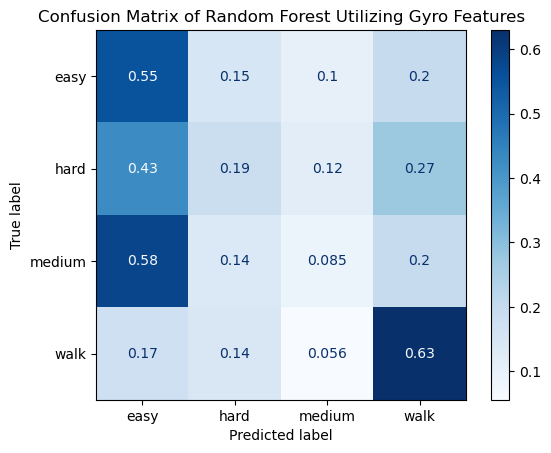

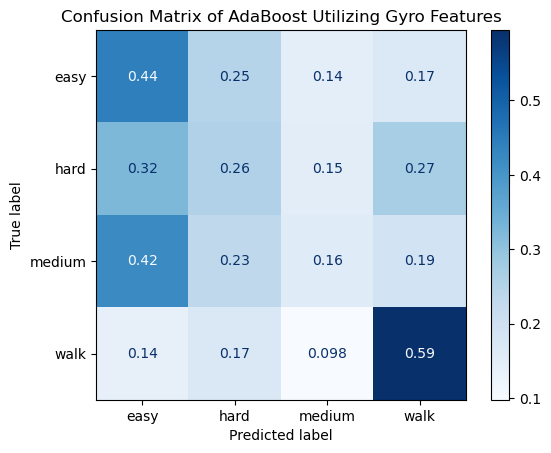

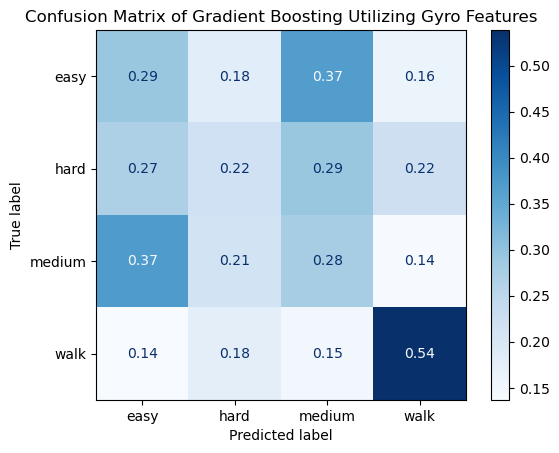

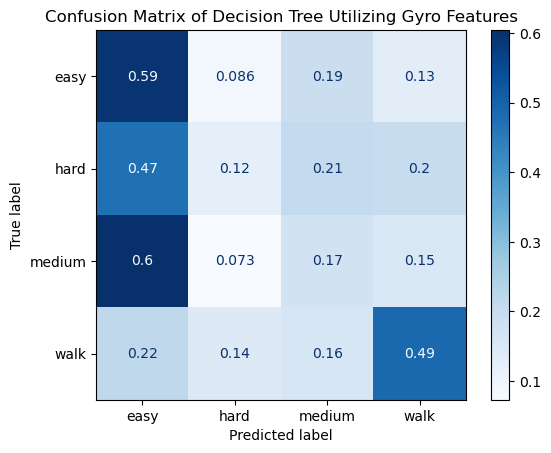

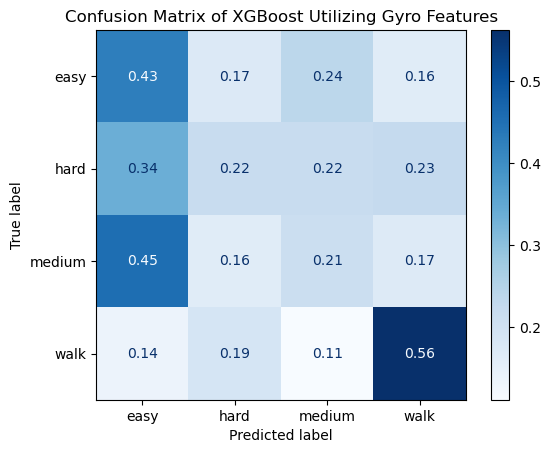

,Classifier,train_acc,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.465,0.391,0.378,0.391,0.366
1,AdaBoost,0.398,0.388,0.388,0.388,0.381
2,Gradient Boosting,0.661,0.359,0.376,0.359,0.366
3,Decision Tree,0.446,0.358,0.376,0.358,0.348
4,XGBoost,0.510,0.380,0.389,0.380,0.380


In [10]:
feature = 'Gyro'
X = encoded_eeg_data[gyro]  
y = encoded_eeg_data['label']

results_dataframe = train_all_classifiers(X, y,features=feature)

# Print the results
results_dataframe
results_dataframe.to_csv("gyro_result.csv",index=False)

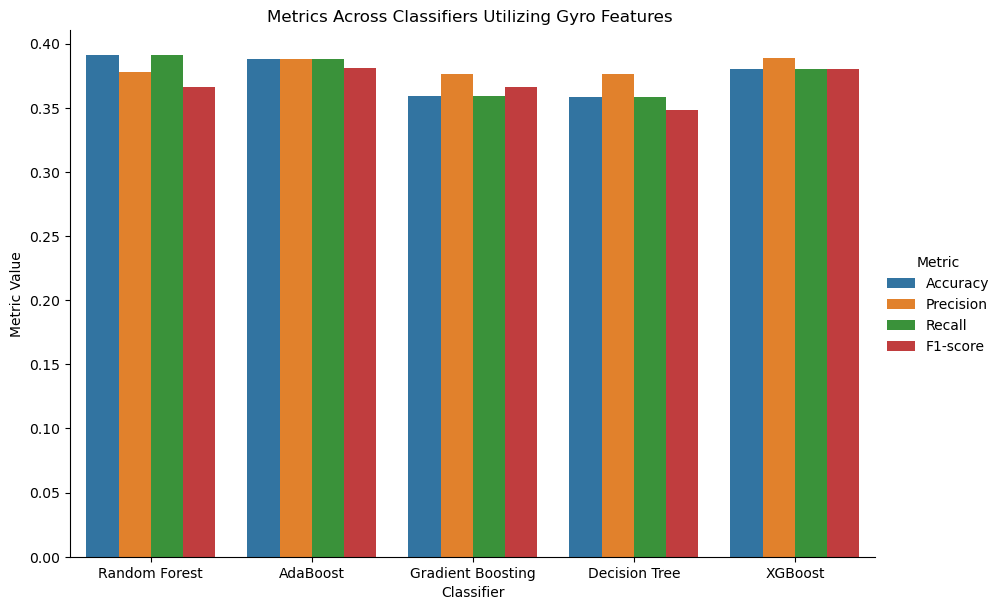

In [11]:
plot_metrics(results_dataframe,features=feature)

# Model train with Accelerometer features

In [ ]:
feature = 'Accelerometer'

X = encoded_eeg_data[acc]  
y = encoded_eeg_data['label']

results_dataframe = train_all_classifiers(X, y,features=feature)

# Print the results
results_dataframe
results_dataframe.to_csv("accelerometer_result.csv",index=False)

In [ ]:
plot_metrics(results_dataframe,features=feature)

# Model train with Raw eeg signals

In [ ]:
feature = 'Raw EEG Signals'
X = encoded_eeg_data[raw_eeg]  
y = encoded_eeg_data['label']

results_dataframe = train_all_classifiers(X, y,features=feature)

# Print the results
results_dataframe
results_dataframe.to_csv("rawEEG_result.csv",index=False)

In [ ]:
plot_metrics(results_dataframe,features=feature)

# Model train with EEG frequency

In [ ]:
feature = 'EEG Frequency'


X = encoded_eeg_data[eeg_frequency]  
y = encoded_eeg_data['label']

results_dataframe = train_all_classifiers(X, y,features=feature)

# Print the results
results_dataframe
results_dataframe.to_csv("eegFrequency_result.csv",index=False)

In [ ]:
plot_metrics(results_dataframe,features=feature)

# Feature selection considering feature selelction method

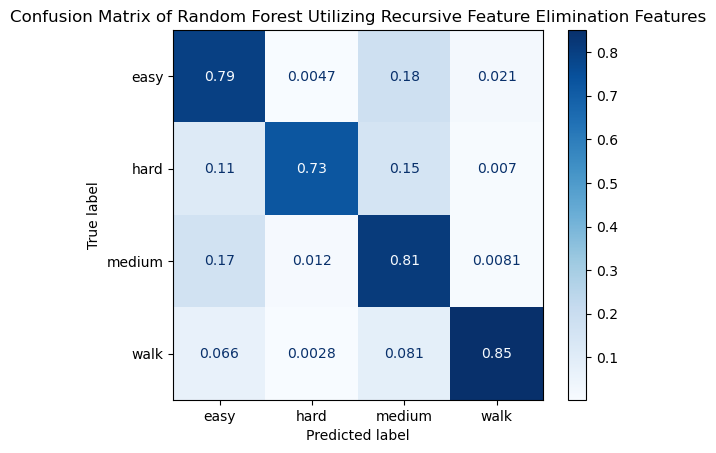

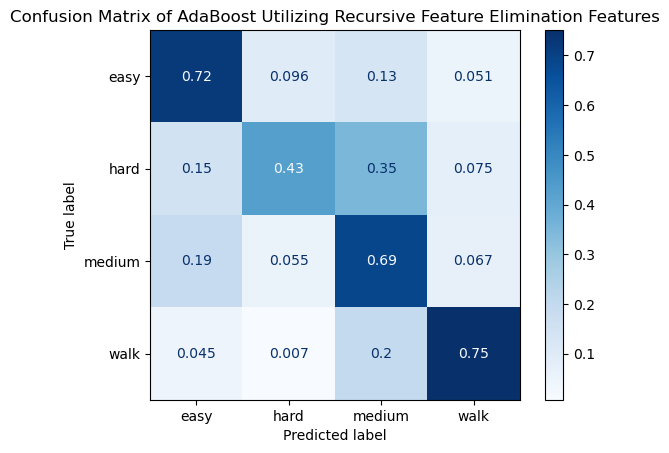

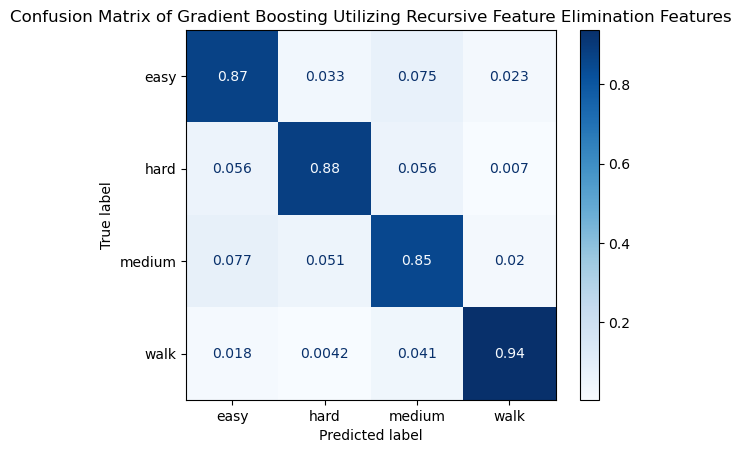

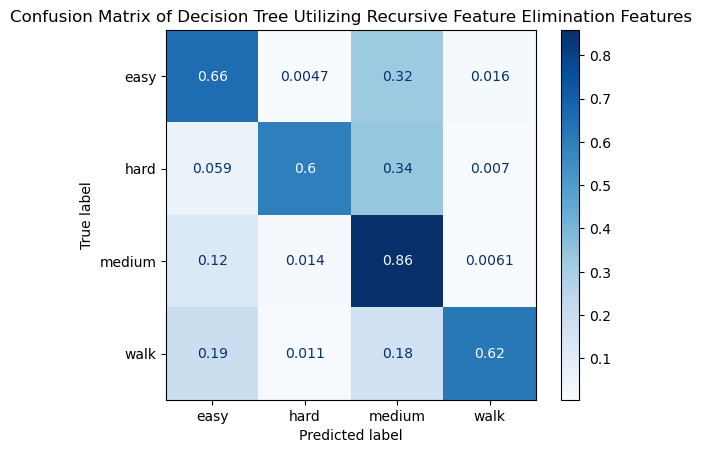

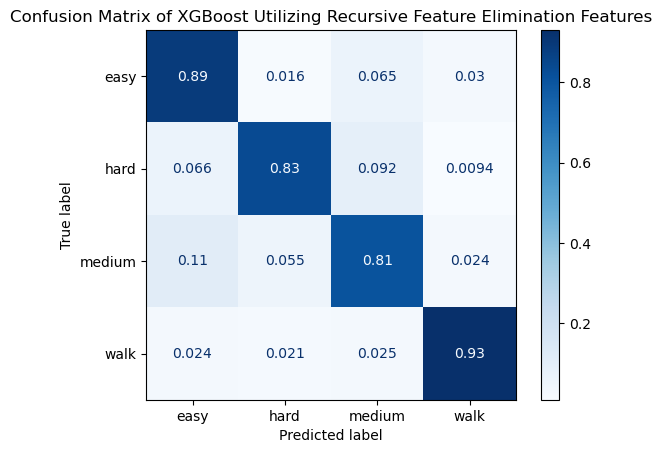

Results from 'Recursive Feature Elimination'


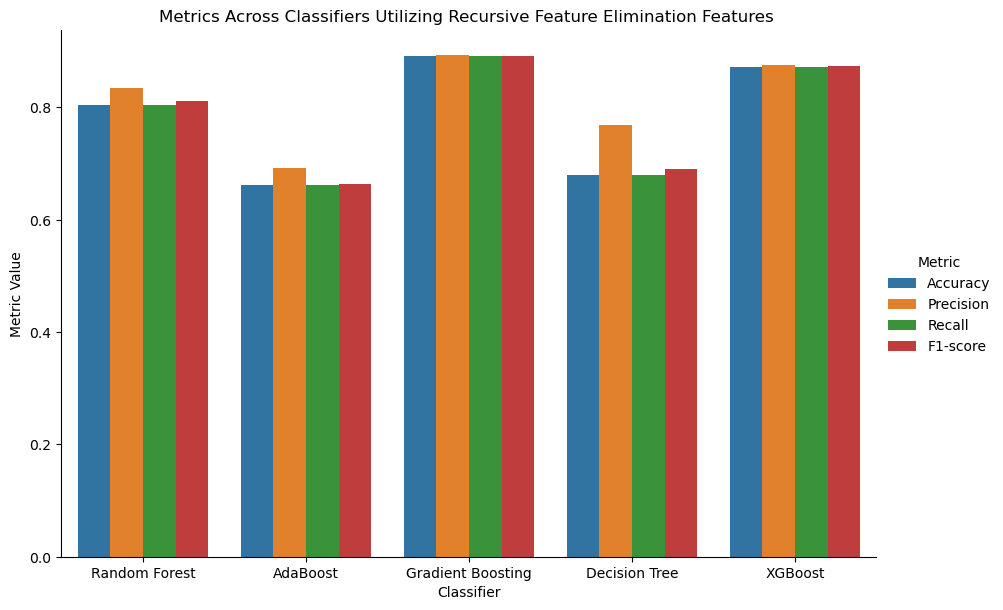

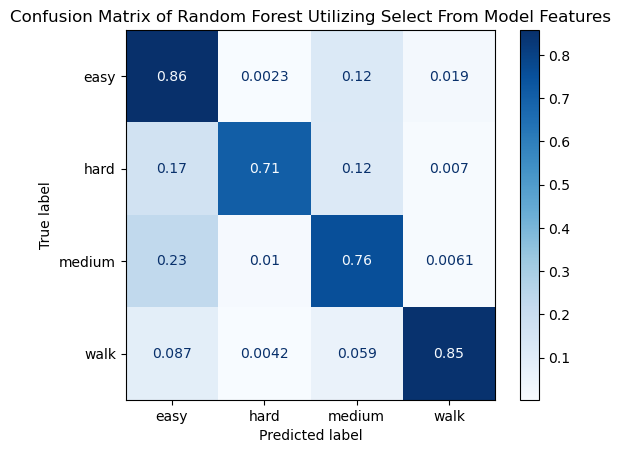

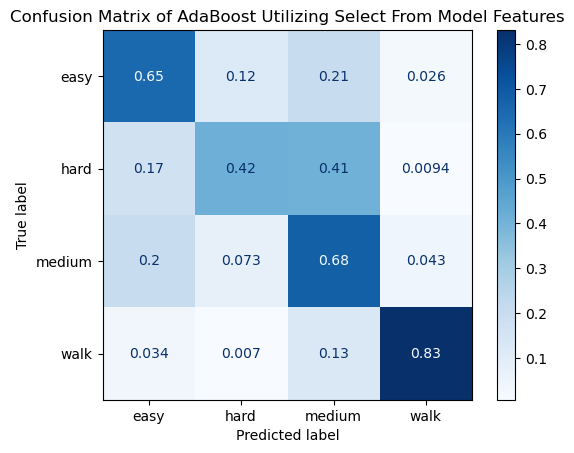

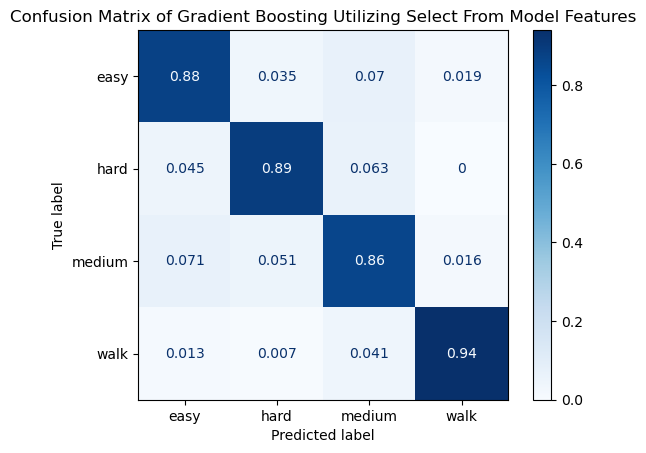

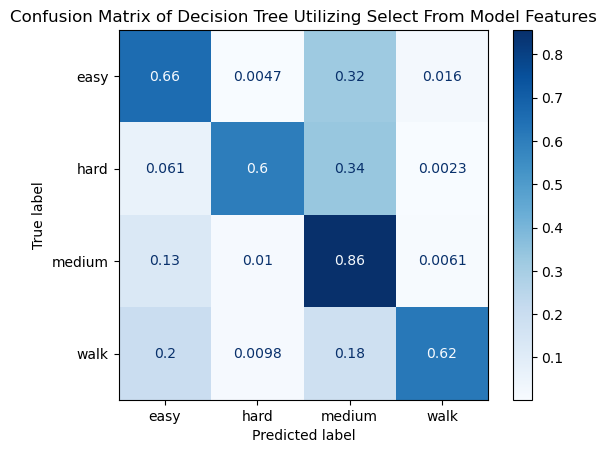

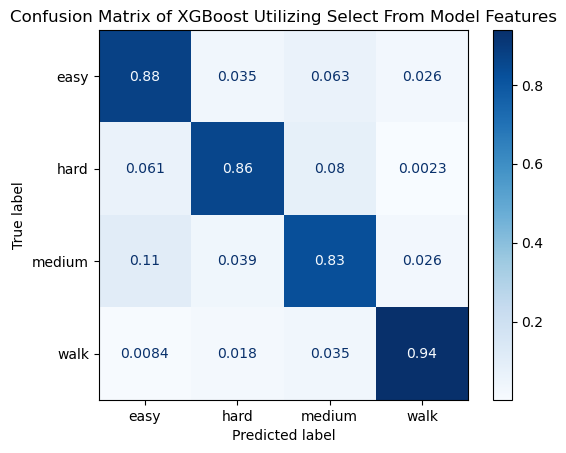

Results from 'Select From Model'


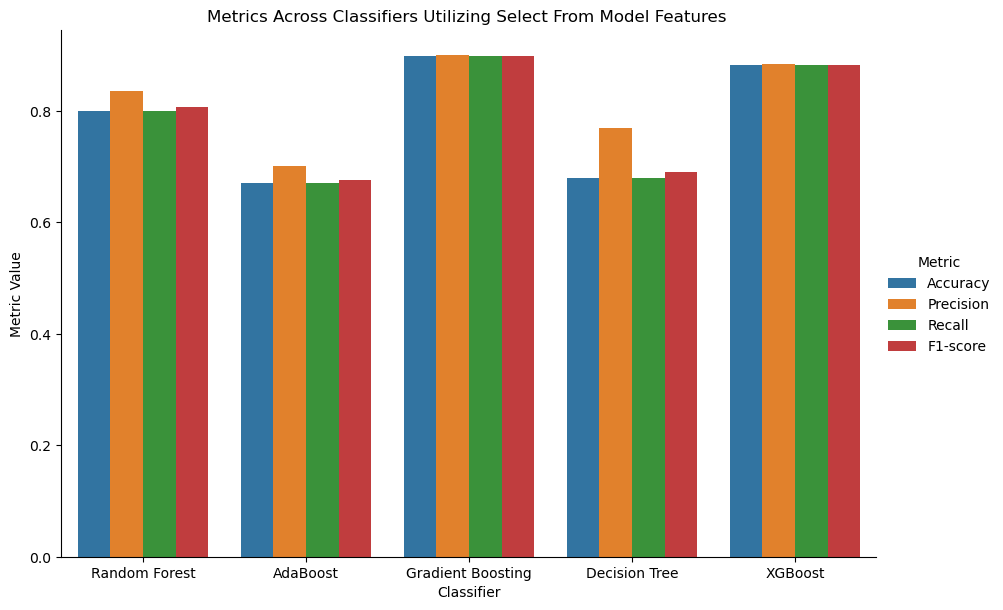

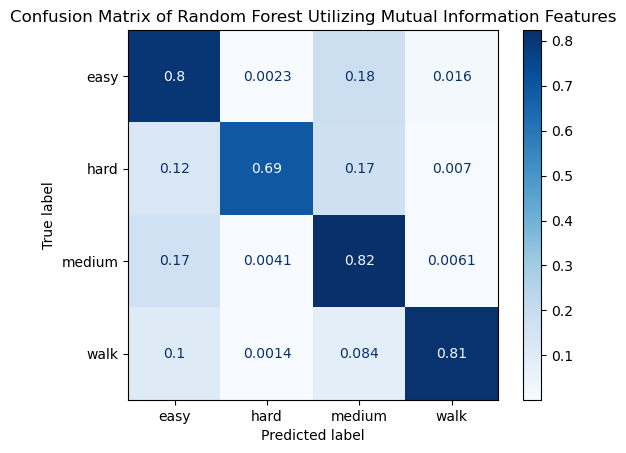

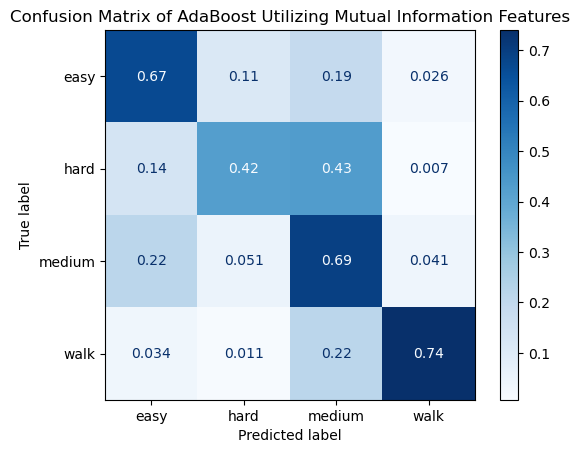

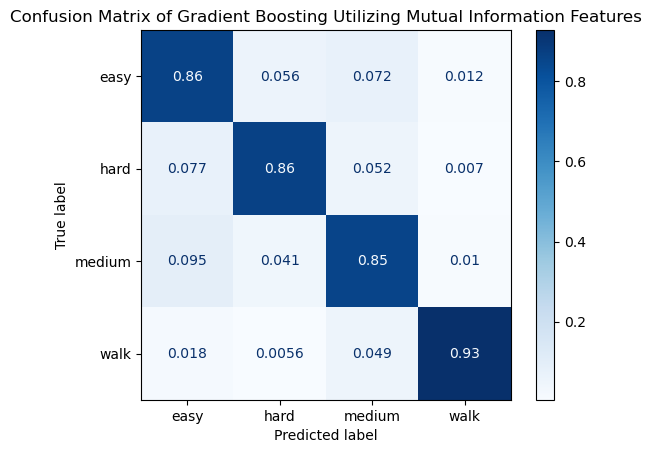

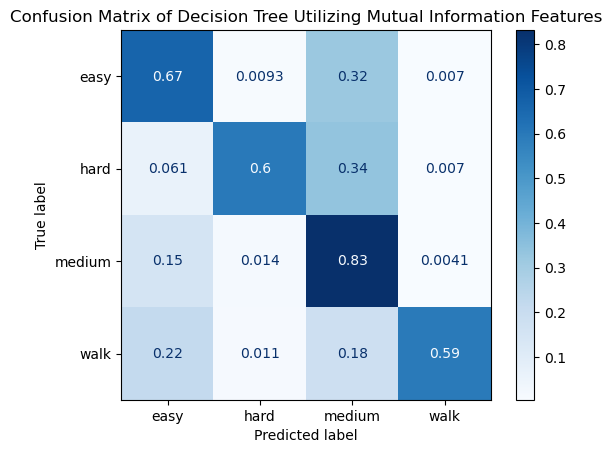

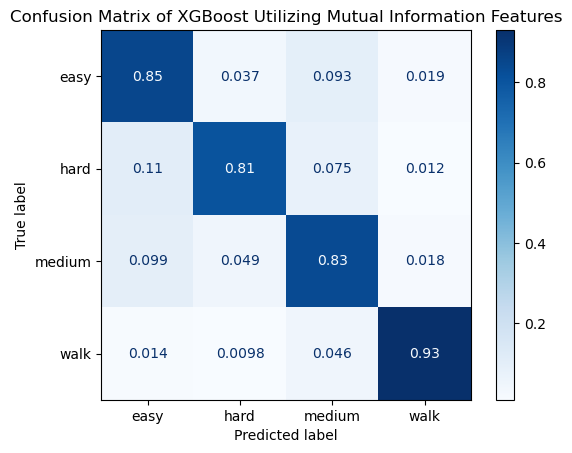

Results from 'Mutual Information'


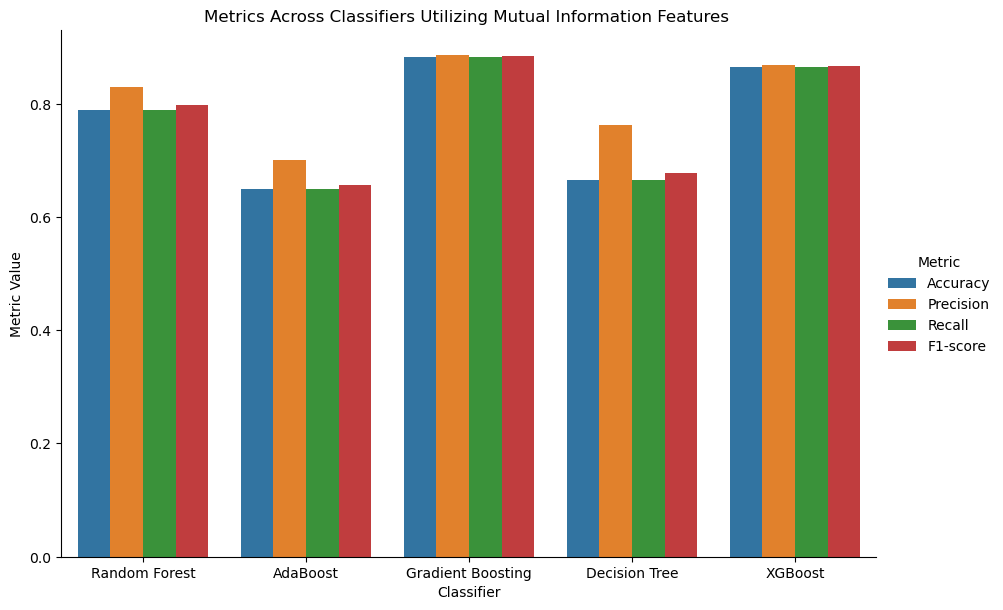

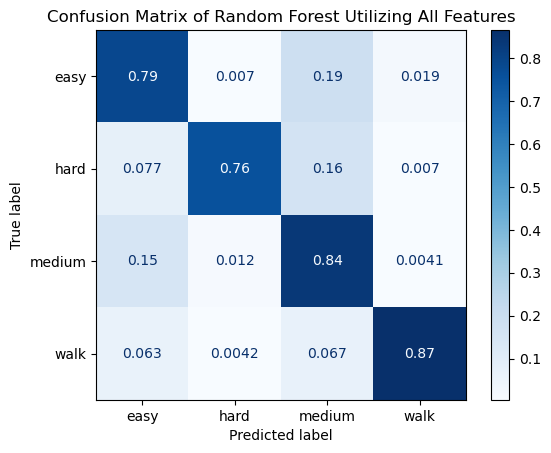

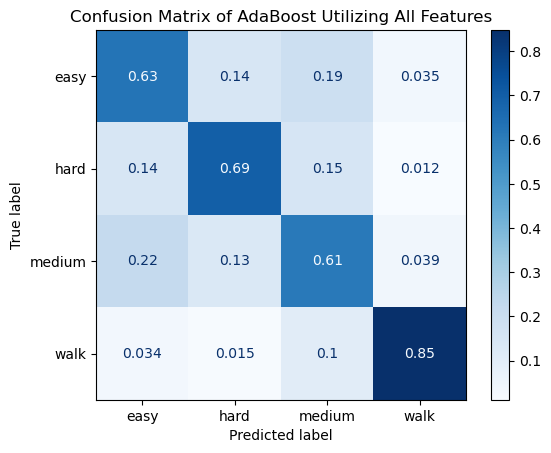

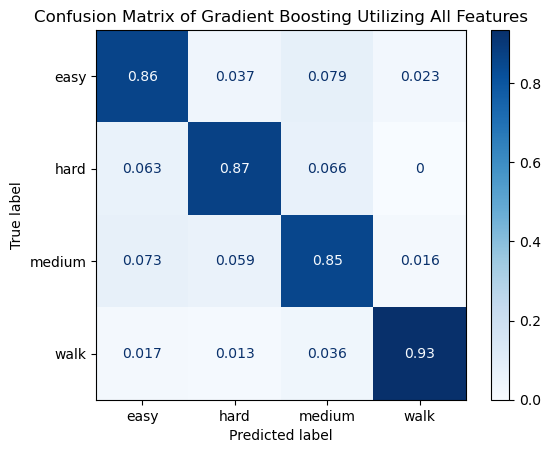

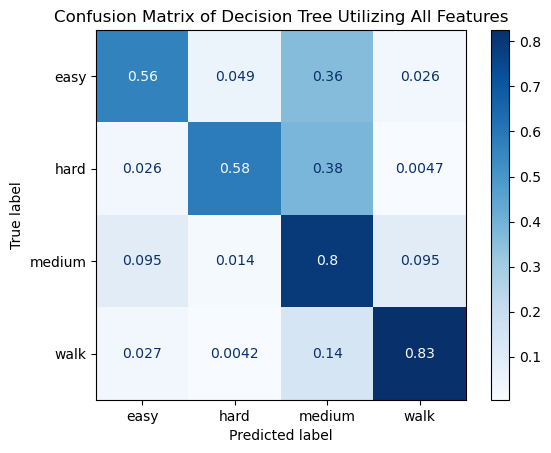

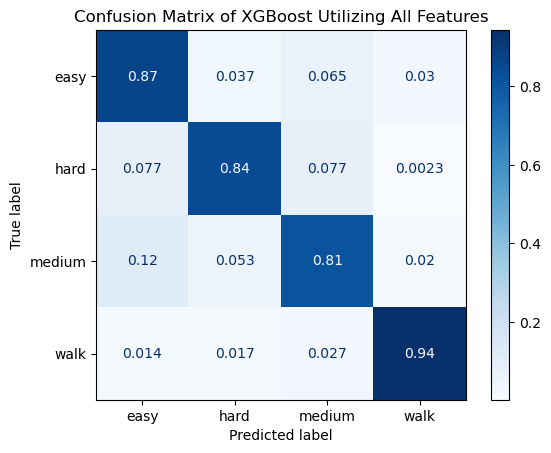

Results from 'All'


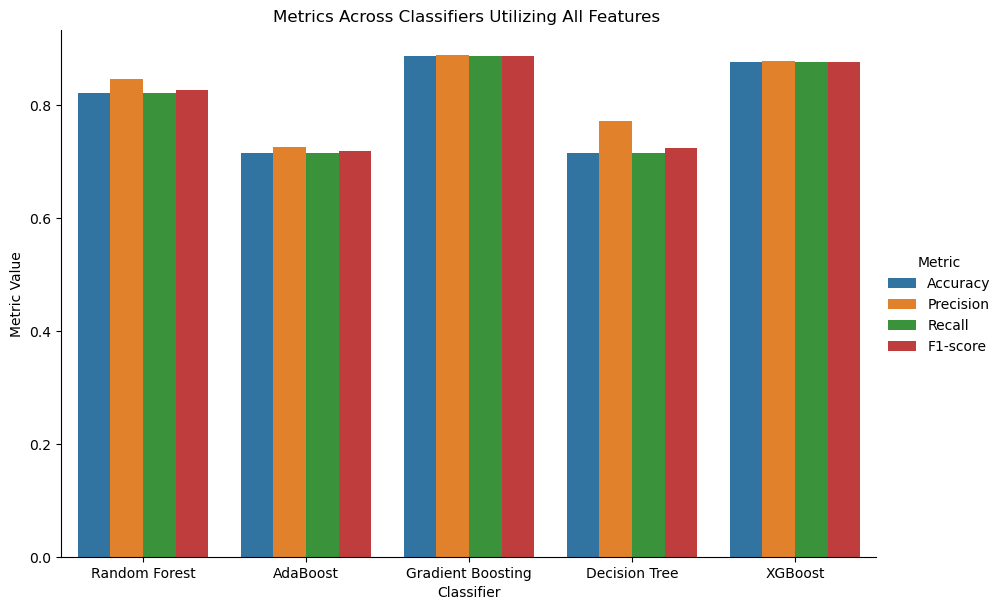

In [12]:
feature_selection_methods = {
    'Recursive Feature Elimination': 'rfe',
    'Select From Model': 'select_from_model',
    'Mutual Information': 'mutual_info',
    'All': 'all'
    
}
features_dataframes = {}
results_dataframes = {}
selected_features_df = pd.DataFrame(columns=['Method', 'Selected Features'])


for key, value in feature_selection_methods.items():
    selected_features = feature_selection(encoded_eeg_data, method=value)
    
    features_dataframes[key] = pd.DataFrame(selected_features)

    
    X = encoded_eeg_data[selected_features]
    y = encoded_eeg_data['label']

    results_dataframe = train_all_classifiers(X, y,features=key)
    
    results_dataframes[key] = results_dataframe
    results_dataframes[key].to_csv("Classification {}.csv".format(key), index=False)

    print("Results from '{}'".format(key))
    #display(results_dataframe)
    plot_metrics(results_dataframe,features=key)

In [ ]:
li = []

for i,j in features_dataframes.items():
    
    df1 = pd.DataFrame(j.values.tolist(),columns=[i])
    
    li.append(df1)
    
ddf= pd.concat(li,axis=1)
ddf

In [ ]:
ddf.to_csv("selected features.csv",index=False)